***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_comprimidas/longitud_8/raw-img-v2')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 955
class_name
Cargo        648
Tanker       211
Container     96
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 765
class_name
Cargo        519
Tanker       169
Container     77
Name: count, dtype: int64

Nº de imágenes en test: 190
class_name
Cargo        129
Tanker        42
Container     19
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
1  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
2  Imagenes\Trayectorias_comprimidas\longitud_8\r...     Tanker
3  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
4  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
5  Imagenes\Trayectorias_comprimidas\longitud_8\r...  Container
6  Imagenes\Trayectorias_comprimidas\longitud_8\r...     Tanker
7  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
8  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo
9  Imagenes\Trayectorias_comprimidas\longitud_8\r...      Cargo

Ejm. conjunto test:
                   

***Imágenes de entrenamiento y test antes del pre-procesado :***

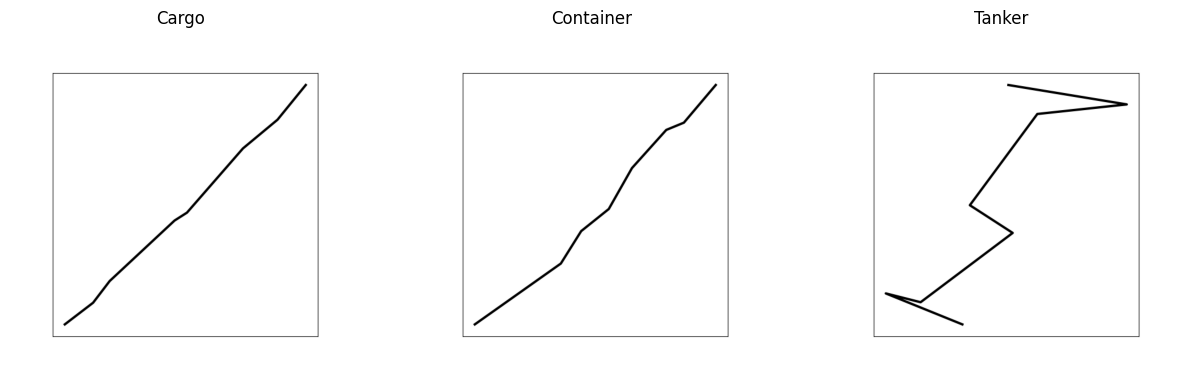

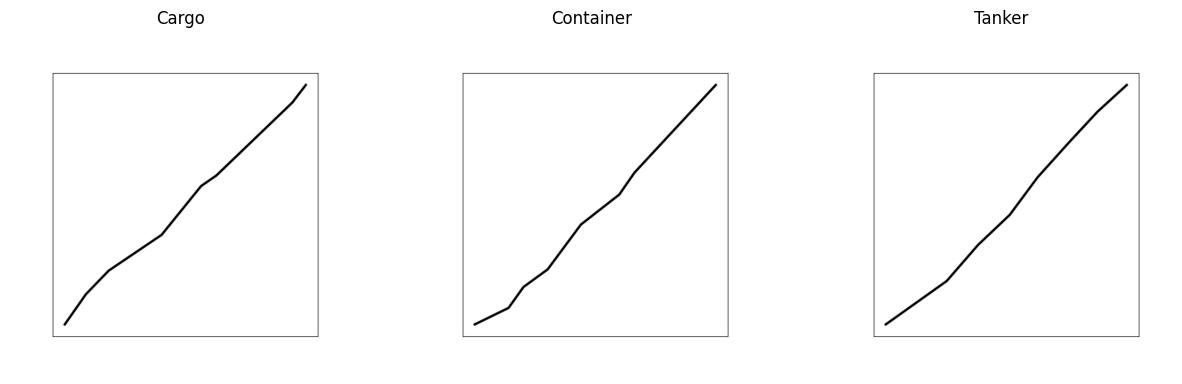

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([765, 3, 227, 227]) cpu
y_train: torch.Size([765]) cpu
X_test: torch.Size([190, 3, 227, 227]) cpu
y_test: torch.Size([190]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [ ]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [ ]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v2/representacion_2/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 29.41% - Train Loss: 1.0994 | Val Acc: 27.45% - Val Loss: 1.0941


Fold 1 | Epoch 2/100: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 43.63% - Train Loss: 1.0351 | Val Acc: 15.69% - Val Loss: 1.2317


Fold 1 | Epoch 3/100: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 41.34% - Train Loss: 1.0431 | Val Acc: 41.83% - Val Loss: 1.0946


Fold 1 | Epoch 4/100: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 41.99% - Train Loss: 1.0559 | Val Acc: 42.48% - Val Loss: 1.0428


Fold 1 | Epoch 5/100: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 40.36% - Train Loss: 1.0169 | Val Acc: 48.37% - Val Loss: 1.0832


Fold 1 | Epoch 6/100: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 47.22% - Train Loss: 1.0129 | Val Acc: 26.14% - Val Loss: 1.2293


Fold 1 | Epoch 7/100: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 44.77% - Train Loss: 1.0377 | Val Acc: 32.68% - Val Loss: 1.1388


Fold 1 | Epoch 8/100: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 46.73% - Train Loss: 1.0439 | Val Acc: 26.14% - Val Loss: 1.1102


Fold 1 | Epoch 9/100: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 43.79% - Train Loss: 0.9923 | Val Acc: 55.56% - Val Loss: 1.0281


Fold 1 | Epoch 10/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 47.39% - Train Loss: 1.0022 | Val Acc: 47.06% - Val Loss: 1.0415


Fold 1 | Epoch 11/100: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 49.35% - Train Loss: 1.0189 | Val Acc: 42.48% - Val Loss: 1.1199


Fold 1 | Epoch 12/100: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 51.63% - Train Loss: 0.9778 | Val Acc: 38.56% - Val Loss: 1.0768


Fold 1 | Epoch 13/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 54.58% - Train Loss: 0.9915 | Val Acc: 22.22% - Val Loss: 1.2047


Fold 1 | Epoch 14/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 45.59% - Train Loss: 0.9938 | Val Acc: 35.29% - Val Loss: 1.1017


Fold 1 | Epoch 15/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 45.26% - Train Loss: 0.9927 | Val Acc: 45.75% - Val Loss: 1.0470


Fold 1 | Epoch 16/100: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 52.61% - Train Loss: 0.9658 | Val Acc: 37.25% - Val Loss: 1.0895


Fold 1 | Epoch 17/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 48.20% - Train Loss: 0.9513 | Val Acc: 58.82% - Val Loss: 1.0030


Fold 1 | Epoch 18/100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 47.88% - Train Loss: 0.9973 | Val Acc: 37.25% - Val Loss: 1.0758


Fold 1 | Epoch 19/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 50.49% - Train Loss: 0.9547 | Val Acc: 52.29% - Val Loss: 1.0489


Fold 1 | Epoch 20/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 51.14% - Train Loss: 0.9777 | Val Acc: 56.86% - Val Loss: 1.0927


Fold 1 | Epoch 21/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 51.80% - Train Loss: 0.9476 | Val Acc: 25.49% - Val Loss: 1.1224


Fold 1 | Epoch 22/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 47.39% - Train Loss: 0.9509 | Val Acc: 39.22% - Val Loss: 1.0930


Fold 1 | Epoch 23/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 52.12% - Train Loss: 0.9816 | Val Acc: 35.95% - Val Loss: 1.0625


Fold 1 | Epoch 24/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 50.00% - Train Loss: 0.9784 | Val Acc: 57.52% - Val Loss: 1.0278


Fold 1 | Epoch 25/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 53.59% - Train Loss: 0.9756 | Val Acc: 27.45% - Val Loss: 1.1387


Fold 1 | Epoch 26/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 51.63% - Train Loss: 0.9479 | Val Acc: 56.86% - Val Loss: 0.9972


Fold 1 | Epoch 27/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 50.98% - Train Loss: 0.9717 | Val Acc: 61.44% - Val Loss: 1.0116


Fold 1 | Epoch 28/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 53.92% - Train Loss: 0.9507 | Val Acc: 50.98% - Val Loss: 1.0523


Fold 1 | Epoch 29/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 45.92% - Train Loss: 0.9873 | Val Acc: 63.40% - Val Loss: 0.9971


Fold 1 | Epoch 30/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 58.99% - Train Loss: 0.9273 | Val Acc: 34.64% - Val Loss: 1.1159


Fold 1 | Epoch 31/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 54.58% - Train Loss: 0.9387 | Val Acc: 52.29% - Val Loss: 1.0453


Fold 1 | Epoch 32/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 50.49% - Train Loss: 0.9398 | Val Acc: 51.63% - Val Loss: 1.0923


Fold 1 | Epoch 33/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 48.20% - Train Loss: 0.9499 | Val Acc: 57.52% - Val Loss: 0.9685


Fold 1 | Epoch 34/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 51.14% - Train Loss: 1.0382 | Val Acc: 22.88% - Val Loss: 1.1703


Fold 1 | Epoch 35/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 50.82% - Train Loss: 0.9860 | Val Acc: 31.37% - Val Loss: 1.1870


Fold 1 | Epoch 36/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 48.69% - Train Loss: 0.9481 | Val Acc: 51.63% - Val Loss: 0.9828


Fold 1 | Epoch 37/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 49.84% - Train Loss: 0.9873 | Val Acc: 60.13% - Val Loss: 1.0239


Fold 1 | Epoch 38/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 55.56% - Train Loss: 0.9607 | Val Acc: 39.87% - Val Loss: 1.0848


Fold 1 | Epoch 39/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 58.01% - Train Loss: 0.9648 | Val Acc: 37.25% - Val Loss: 1.1045


Fold 1 | Epoch 40/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 54.41% - Train Loss: 0.9378 | Val Acc: 40.52% - Val Loss: 1.0330


Fold 1 | Epoch 41/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 53.59% - Train Loss: 0.9341 | Val Acc: 36.60% - Val Loss: 1.0888


Fold 1 | Epoch 42/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 51.96% - Train Loss: 0.9219 | Val Acc: 57.52% - Val Loss: 0.9833


Fold 1 | Epoch 43/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 57.03% - Train Loss: 0.9801 | Val Acc: 28.10% - Val Loss: 1.1569


Fold 1 | Epoch 44/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 55.72% - Train Loss: 0.9435 | Val Acc: 32.03% - Val Loss: 1.2662


Fold 1 | Epoch 45/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 52.61% - Train Loss: 0.9730 | Val Acc: 42.48% - Val Loss: 1.0795


Fold 1 | Epoch 46/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 50.82% - Train Loss: 0.9427 | Val Acc: 65.36% - Val Loss: 0.9924


Fold 1 | Epoch 47/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 50.16% - Train Loss: 0.9684 | Val Acc: 50.98% - Val Loss: 0.9887


Fold 1 | Epoch 48/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 56.05% - Train Loss: 0.9359 | Val Acc: 24.84% - Val Loss: 1.2731


Fold 1 | Epoch 49/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 56.86% - Train Loss: 0.9265 | Val Acc: 40.52% - Val Loss: 1.0456


Fold 1 | Epoch 50/100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 50.65% - Train Loss: 0.9621 | Val Acc: 41.83% - Val Loss: 1.0120


Fold 1 | Epoch 51/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 53.43% - Train Loss: 0.9414 | Val Acc: 56.21% - Val Loss: 0.9813


Fold 1 | Epoch 52/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 57.84% - Train Loss: 0.9526 | Val Acc: 30.72% - Val Loss: 1.1340


Fold 1 | Epoch 53/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 57.35% - Train Loss: 0.9226 | Val Acc: 32.68% - Val Loss: 1.1353


Fold 1 | Epoch 54/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 49.84% - Train Loss: 0.9479 | Val Acc: 44.44% - Val Loss: 1.0171


Fold 1 | Epoch 55/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 50.98% - Train Loss: 0.9485 | Val Acc: 60.78% - Val Loss: 0.9737


Fold 1 | Epoch 56/100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 58.66% - Train Loss: 0.9297 | Val Acc: 28.10% - Val Loss: 1.1224


Fold 1 | Epoch 57/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 55.23% - Train Loss: 0.9121 | Val Acc: 54.25% - Val Loss: 1.0346


Fold 1 | Epoch 58/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 54.08% - Train Loss: 0.9370 | Val Acc: 53.59% - Val Loss: 0.9738


Fold 1 | Epoch 59/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 50.65% - Train Loss: 0.9471 | Val Acc: 58.82% - Val Loss: 1.0260


Fold 1 | Epoch 60/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 57.52% - Train Loss: 0.9093 | Val Acc: 57.52% - Val Loss: 1.0643


Fold 1 | Epoch 61/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 57.52% - Train Loss: 0.8929 | Val Acc: 44.44% - Val Loss: 1.0358


Fold 1 | Epoch 62/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 58.50% - Train Loss: 0.9475 | Val Acc: 40.52% - Val Loss: 1.0652


Fold 1 | Epoch 63/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 54.58% - Train Loss: 0.9390 | Val Acc: 63.40% - Val Loss: 1.0142


Fold 1 | Epoch 64/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 57.52% - Train Loss: 0.9097 | Val Acc: 32.68% - Val Loss: 1.1295


Fold 1 | Epoch 65/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 55.07% - Train Loss: 0.8969 | Val Acc: 55.56% - Val Loss: 0.9922


Fold 1 | Epoch 66/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 54.74% - Train Loss: 0.9391 | Val Acc: 67.97% - Val Loss: 0.9587


Fold 1 | Epoch 67/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 49.67% - Train Loss: 0.9346 | Val Acc: 63.40% - Val Loss: 1.1256


Fold 1 | Epoch 68/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 55.07% - Train Loss: 0.9276 | Val Acc: 48.37% - Val Loss: 0.9980


Fold 1 | Epoch 69/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 52.94% - Train Loss: 0.9491 | Val Acc: 52.94% - Val Loss: 1.0125


Fold 1 | Epoch 70/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 52.29% - Train Loss: 0.9923 | Val Acc: 49.67% - Val Loss: 1.0822


Fold 1 | Epoch 71/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 58.99% - Train Loss: 0.9544 | Val Acc: 24.18% - Val Loss: 1.2355


Fold 1 | Epoch 72/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 55.88% - Train Loss: 0.9150 | Val Acc: 52.94% - Val Loss: 0.9800


Fold 1 | Epoch 73/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 48.69% - Train Loss: 0.9145 | Val Acc: 66.01% - Val Loss: 0.9390


Fold 1 | Epoch 74/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 55.88% - Train Loss: 0.9537 | Val Acc: 35.29% - Val Loss: 1.0876


Fold 1 | Epoch 75/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 55.56% - Train Loss: 0.8904 | Val Acc: 54.25% - Val Loss: 1.0562


Fold 1 | Epoch 76/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 56.86% - Train Loss: 0.8963 | Val Acc: 50.98% - Val Loss: 1.0101


Fold 1 | Epoch 77/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 58.33% - Train Loss: 0.9183 | Val Acc: 42.48% - Val Loss: 1.0668


Fold 1 | Epoch 78/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 56.54% - Train Loss: 0.9079 | Val Acc: 52.94% - Val Loss: 0.9949


Fold 1 | Epoch 79/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 58.99% - Train Loss: 0.9004 | Val Acc: 35.95% - Val Loss: 1.1127


Fold 1 | Epoch 80/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 50.65% - Train Loss: 0.9227 | Val Acc: 62.75% - Val Loss: 1.0481


Fold 1 | Epoch 81/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 52.61% - Train Loss: 0.9757 | Val Acc: 55.56% - Val Loss: 0.9488


Fold 1 | Epoch 82/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 51.96% - Train Loss: 0.9410 | Val Acc: 60.13% - Val Loss: 0.9576


Fold 1 | Epoch 83/100: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 55.56% - Train Loss: 0.8896 | Val Acc: 39.87% - Val Loss: 1.1070


Fold 1 | Epoch 84/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 50.82% - Train Loss: 0.9037 | Val Acc: 63.40% - Val Loss: 1.0277


Fold 1 | Epoch 85/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 55.39% - Train Loss: 0.9178 | Val Acc: 58.17% - Val Loss: 0.9451


Fold 1 | Epoch 86/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 53.27% - Train Loss: 0.8994 | Val Acc: 61.44% - Val Loss: 1.0025


Fold 1 | Epoch 87/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 55.07% - Train Loss: 0.9224 | Val Acc: 30.72% - Val Loss: 1.0926


Fold 1 | Epoch 88/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 54.25% - Train Loss: 0.9111 | Val Acc: 53.59% - Val Loss: 0.9742


Fold 1 | Epoch 89/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 55.07% - Train Loss: 0.9432 | Val Acc: 32.03% - Val Loss: 1.0980


Fold 1 | Epoch 90/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 57.84% - Train Loss: 0.9337 | Val Acc: 37.91% - Val Loss: 1.0296


Fold 1 | Epoch 91/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 56.05% - Train Loss: 0.9182 | Val Acc: 32.68% - Val Loss: 1.0798


Fold 1 | Epoch 92/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 52.78% - Train Loss: 0.9017 | Val Acc: 67.32% - Val Loss: 0.9519


Fold 1 | Epoch 93/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 55.07% - Train Loss: 0.9448 | Val Acc: 58.82% - Val Loss: 0.9808


Fold 1 | Epoch 94/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 55.56% - Train Loss: 0.9359 | Val Acc: 40.52% - Val Loss: 1.0031


Fold 1 | Epoch 95/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 54.90% - Train Loss: 0.8955 | Val Acc: 39.87% - Val Loss: 1.0604


Fold 1 | Epoch 96/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 54.74% - Train Loss: 0.8954 | Val Acc: 56.21% - Val Loss: 0.9928


Fold 1 | Epoch 97/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 56.21% - Train Loss: 0.9067 | Val Acc: 65.36% - Val Loss: 0.9666


Fold 1 | Epoch 98/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 59.97% - Train Loss: 0.9009 | Val Acc: 32.03% - Val Loss: 1.1089


Fold 1 | Epoch 99/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 57.19% - Train Loss: 0.9236 | Val Acc: 32.68% - Val Loss: 1.1150


Fold 1 | Epoch 100/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 59.31% - Train Loss: 0.9529 | Val Acc: 42.48% - Val Loss: 1.0264

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 44.12% - Train Loss: 1.0837 | Val Acc: 44.44% - Val Loss: 1.0357


Fold 2 | Epoch 2/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 38.40% - Train Loss: 1.0554 | Val Acc: 45.75% - Val Loss: 1.1018


Fold 2 | Epoch 3/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 47.88% - Train Loss: 1.0614 | Val Acc: 35.29% - Val Loss: 1.0433


Fold 2 | Epoch 4/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 43.79% - Train Loss: 1.0303 | Val Acc: 48.37% - Val Loss: 1.0050


Fold 2 | Epoch 5/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 47.88% - Train Loss: 1.0275 | Val Acc: 47.06% - Val Loss: 1.0238


Fold 2 | Epoch 6/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 43.30% - Train Loss: 1.0483 | Val Acc: 59.48% - Val Loss: 1.0076


Fold 2 | Epoch 7/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 45.59% - Train Loss: 1.0015 | Val Acc: 63.40% - Val Loss: 1.0480


Fold 2 | Epoch 8/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 57.35% - Train Loss: 1.0033 | Val Acc: 49.67% - Val Loss: 1.0001


Fold 2 | Epoch 9/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 47.55% - Train Loss: 1.0073 | Val Acc: 45.75% - Val Loss: 1.0158


Fold 2 | Epoch 10/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 58.66% - Train Loss: 1.0044 | Val Acc: 33.99% - Val Loss: 1.0100


Fold 2 | Epoch 11/100: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 45.10% - Train Loss: 0.9930 | Val Acc: 58.17% - Val Loss: 1.0571


Fold 2 | Epoch 12/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 48.86% - Train Loss: 0.9808 | Val Acc: 61.44% - Val Loss: 1.0128


Fold 2 | Epoch 13/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 52.94% - Train Loss: 1.0405 | Val Acc: 31.37% - Val Loss: 1.0560


Fold 2 | Epoch 14/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 49.18% - Train Loss: 1.0102 | Val Acc: 52.94% - Val Loss: 1.0046


Fold 2 | Epoch 15/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 57.84% - Train Loss: 1.0156 | Val Acc: 61.44% - Val Loss: 1.0115


Fold 2 | Epoch 16/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 57.52% - Train Loss: 0.9874 | Val Acc: 42.48% - Val Loss: 1.0113


Fold 2 | Epoch 17/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 47.71% - Train Loss: 0.9648 | Val Acc: 55.56% - Val Loss: 1.1030


Fold 2 | Epoch 18/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 49.51% - Train Loss: 1.0027 | Val Acc: 47.71% - Val Loss: 1.0209


Fold 2 | Epoch 19/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 54.90% - Train Loss: 0.9693 | Val Acc: 56.86% - Val Loss: 1.0129


Fold 2 | Epoch 20/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 59.48% - Train Loss: 1.0220 | Val Acc: 37.91% - Val Loss: 1.0056


Fold 2 | Epoch 21/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 55.72% - Train Loss: 0.9720 | Val Acc: 54.90% - Val Loss: 1.0398


Fold 2 | Epoch 22/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 51.47% - Train Loss: 0.9795 | Val Acc: 52.94% - Val Loss: 1.0203


Fold 2 | Epoch 23/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 56.37% - Train Loss: 0.9446 | Val Acc: 52.94% - Val Loss: 1.0034


Fold 2 | Epoch 24/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 50.98% - Train Loss: 0.9653 | Val Acc: 52.29% - Val Loss: 1.0089


Fold 2 | Epoch 25/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 59.48% - Train Loss: 0.9549 | Val Acc: 52.94% - Val Loss: 0.9971


Fold 2 | Epoch 26/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 54.74% - Train Loss: 0.9877 | Val Acc: 50.33% - Val Loss: 1.0394


Fold 2 | Epoch 27/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 55.39% - Train Loss: 0.9918 | Val Acc: 57.52% - Val Loss: 1.0228


Fold 2 | Epoch 28/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 49.35% - Train Loss: 0.9762 | Val Acc: 61.44% - Val Loss: 1.0675


Fold 2 | Epoch 29/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 51.14% - Train Loss: 0.9666 | Val Acc: 60.13% - Val Loss: 1.0182


Fold 2 | Epoch 30/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 57.03% - Train Loss: 0.9673 | Val Acc: 50.98% - Val Loss: 0.9893


Fold 2 | Epoch 31/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 57.84% - Train Loss: 0.9441 | Val Acc: 50.98% - Val Loss: 1.0006


Fold 2 | Epoch 32/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 55.72% - Train Loss: 0.9604 | Val Acc: 54.90% - Val Loss: 1.0604


Fold 2 | Epoch 33/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 53.92% - Train Loss: 0.9904 | Val Acc: 58.17% - Val Loss: 0.9908


Fold 2 | Epoch 34/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 57.84% - Train Loss: 0.9688 | Val Acc: 56.21% - Val Loss: 0.9935


Fold 2 | Epoch 35/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 58.99% - Train Loss: 0.9558 | Val Acc: 56.86% - Val Loss: 1.0014


Fold 2 | Epoch 36/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 52.45% - Train Loss: 0.9182 | Val Acc: 60.78% - Val Loss: 1.0258


Fold 2 | Epoch 37/100: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 57.19% - Train Loss: 0.9521 | Val Acc: 50.33% - Val Loss: 0.9998


Fold 2 | Epoch 38/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 55.88% - Train Loss: 0.9809 | Val Acc: 56.86% - Val Loss: 0.9846


Fold 2 | Epoch 39/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 54.41% - Train Loss: 0.9486 | Val Acc: 59.48% - Val Loss: 1.0031


Fold 2 | Epoch 40/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 53.43% - Train Loss: 0.9364 | Val Acc: 58.82% - Val Loss: 1.0104


Fold 2 | Epoch 41/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 60.13% - Train Loss: 0.9381 | Val Acc: 32.68% - Val Loss: 1.0180


Fold 2 | Epoch 42/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 49.51% - Train Loss: 0.9698 | Val Acc: 49.67% - Val Loss: 0.9998


Fold 2 | Epoch 43/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 55.39% - Train Loss: 0.9483 | Val Acc: 58.82% - Val Loss: 1.0307


Fold 2 | Epoch 44/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 54.74% - Train Loss: 0.9446 | Val Acc: 58.17% - Val Loss: 1.0002


Fold 2 | Epoch 45/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 58.01% - Train Loss: 0.9277 | Val Acc: 54.90% - Val Loss: 1.0046


Fold 2 | Epoch 46/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 60.62% - Train Loss: 0.9077 | Val Acc: 60.13% - Val Loss: 1.0011


Fold 2 | Epoch 47/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 57.03% - Train Loss: 0.9223 | Val Acc: 56.21% - Val Loss: 1.0403


Fold 2 | Epoch 48/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 53.76% - Train Loss: 0.9538 | Val Acc: 59.48% - Val Loss: 1.0815


Fold 2 | Epoch 49/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 56.21% - Train Loss: 0.9456 | Val Acc: 53.59% - Val Loss: 1.0101


Fold 2 | Epoch 50/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 61.60% - Train Loss: 0.9582 | Val Acc: 58.17% - Val Loss: 0.9935


Fold 2 | Epoch 51/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 58.01% - Train Loss: 0.9226 | Val Acc: 49.02% - Val Loss: 1.0251


Fold 2 | Epoch 52/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 53.92% - Train Loss: 0.9302 | Val Acc: 56.21% - Val Loss: 1.0335


Fold 2 | Epoch 53/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 60.13% - Train Loss: 0.9400 | Val Acc: 56.21% - Val Loss: 1.0120


Fold 2 | Epoch 54/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 58.01% - Train Loss: 0.9480 | Val Acc: 49.67% - Val Loss: 1.0100


Fold 2 | Epoch 55/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 54.41% - Train Loss: 0.9167 | Val Acc: 56.86% - Val Loss: 1.0131


Fold 2 | Epoch 56/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 59.48% - Train Loss: 0.9426 | Val Acc: 58.17% - Val Loss: 1.0218


Fold 2 | Epoch 57/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 60.13% - Train Loss: 0.9333 | Val Acc: 47.71% - Val Loss: 1.0407


Fold 2 | Epoch 58/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 58.01% - Train Loss: 0.9528 | Val Acc: 57.52% - Val Loss: 0.9864


Fold 2 | Epoch 59/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 52.94% - Train Loss: 0.9191 | Val Acc: 58.17% - Val Loss: 1.0007


Fold 2 | Epoch 60/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 57.52% - Train Loss: 0.9303 | Val Acc: 56.86% - Val Loss: 1.0224


Fold 2 | Epoch 61/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 52.61% - Train Loss: 0.9455 | Val Acc: 56.21% - Val Loss: 0.9895


Fold 2 | Epoch 62/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 51.31% - Train Loss: 0.9093 | Val Acc: 58.17% - Val Loss: 1.0286


Fold 2 | Epoch 63/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 55.23% - Train Loss: 0.9277 | Val Acc: 45.75% - Val Loss: 1.0013


Fold 2 | Epoch 64/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 55.07% - Train Loss: 0.9485 | Val Acc: 56.86% - Val Loss: 0.9975


Fold 2 | Epoch 65/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 59.48% - Train Loss: 0.9181 | Val Acc: 50.33% - Val Loss: 1.0436


Fold 2 | Epoch 66/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 53.27% - Train Loss: 0.9558 | Val Acc: 54.25% - Val Loss: 0.9878


Fold 2 | Epoch 67/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 58.17% - Train Loss: 0.9367 | Val Acc: 58.82% - Val Loss: 1.0159


Fold 2 | Epoch 68/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 59.48% - Train Loss: 0.9185 | Val Acc: 57.52% - Val Loss: 1.0079


Fold 2 | Epoch 69/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 57.19% - Train Loss: 0.9017 | Val Acc: 52.29% - Val Loss: 0.9939


Fold 2 | Epoch 70/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 59.15% - Train Loss: 0.9020 | Val Acc: 58.17% - Val Loss: 1.0233


Fold 2 | Epoch 71/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 60.46% - Train Loss: 0.9331 | Val Acc: 58.82% - Val Loss: 1.0255


Fold 2 | Epoch 72/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 56.70% - Train Loss: 0.9427 | Val Acc: 50.98% - Val Loss: 0.9973


Fold 2 | Epoch 73/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 57.52% - Train Loss: 0.8892 | Val Acc: 58.82% - Val Loss: 1.0334


Fold 2 | Epoch 74/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 53.59% - Train Loss: 0.9207 | Val Acc: 57.52% - Val Loss: 1.0567


Fold 2 | Epoch 75/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 58.33% - Train Loss: 0.9614 | Val Acc: 47.71% - Val Loss: 1.0060


Fold 2 | Epoch 76/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 63.56% - Train Loss: 0.9275 | Val Acc: 48.37% - Val Loss: 0.9968


Fold 2 | Epoch 77/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 57.19% - Train Loss: 0.9224 | Val Acc: 54.90% - Val Loss: 0.9920


Fold 2 | Epoch 78/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 57.03% - Train Loss: 0.9380 | Val Acc: 50.33% - Val Loss: 1.0000


Fold 2 | Epoch 79/100: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 58.66% - Train Loss: 0.9334 | Val Acc: 41.83% - Val Loss: 1.0720


Fold 2 | Epoch 80/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 52.29% - Train Loss: 0.9211 | Val Acc: 58.82% - Val Loss: 1.0315


Fold 2 | Epoch 81/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 58.33% - Train Loss: 0.9442 | Val Acc: 54.25% - Val Loss: 0.9975


Fold 2 | Epoch 82/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 57.68% - Train Loss: 0.9133 | Val Acc: 58.82% - Val Loss: 0.9959


Fold 2 | Epoch 83/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 53.59% - Train Loss: 0.9326 | Val Acc: 60.78% - Val Loss: 1.0702


Fold 2 | Epoch 84/100: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 54.41% - Train Loss: 0.9262 | Val Acc: 58.17% - Val Loss: 1.0104


Fold 2 | Epoch 85/100: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 61.44% - Train Loss: 0.9187 | Val Acc: 45.10% - Val Loss: 1.0665


Fold 2 | Epoch 86/100: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 57.19% - Train Loss: 0.8924 | Val Acc: 56.86% - Val Loss: 1.0476


Fold 2 | Epoch 87/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 59.80% - Train Loss: 0.9081 | Val Acc: 58.17% - Val Loss: 1.0138


Fold 2 | Epoch 88/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 56.54% - Train Loss: 0.9077 | Val Acc: 56.86% - Val Loss: 1.0363


Fold 2 | Epoch 89/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 58.33% - Train Loss: 0.9218 | Val Acc: 45.10% - Val Loss: 1.0011


Fold 2 | Epoch 90/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 56.05% - Train Loss: 0.9332 | Val Acc: 52.29% - Val Loss: 1.0006


Fold 2 | Epoch 91/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 56.37% - Train Loss: 0.9134 | Val Acc: 58.82% - Val Loss: 0.9978


Fold 2 | Epoch 92/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 59.31% - Train Loss: 0.9137 | Val Acc: 41.83% - Val Loss: 1.0768


Fold 2 | Epoch 93/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 59.48% - Train Loss: 0.9278 | Val Acc: 46.41% - Val Loss: 0.9934


Fold 2 | Epoch 94/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 52.94% - Train Loss: 0.9131 | Val Acc: 56.86% - Val Loss: 1.0197


Fold 2 | Epoch 95/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 58.66% - Train Loss: 0.9050 | Val Acc: 58.17% - Val Loss: 1.0201


Fold 2 | Epoch 96/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 58.82% - Train Loss: 0.8842 | Val Acc: 51.63% - Val Loss: 0.9922


Fold 2 | Epoch 97/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 58.66% - Train Loss: 0.9109 | Val Acc: 57.52% - Val Loss: 1.0370


Fold 2 | Epoch 98/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 55.72% - Train Loss: 0.9153 | Val Acc: 56.86% - Val Loss: 1.0045


Fold 2 | Epoch 99/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 57.68% - Train Loss: 0.9323 | Val Acc: 49.67% - Val Loss: 0.9848


Fold 2 | Epoch 100/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 55.39% - Train Loss: 0.9196 | Val Acc: 59.48% - Val Loss: 1.0133

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 42.81% - Train Loss: 1.0910 | Val Acc: 50.98% - Val Loss: 1.1113


Fold 3 | Epoch 2/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 49.67% - Train Loss: 1.0340 | Val Acc: 32.03% - Val Loss: 1.0281


Fold 3 | Epoch 3/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 47.06% - Train Loss: 1.0288 | Val Acc: 52.29% - Val Loss: 1.0694


Fold 3 | Epoch 4/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 48.04% - Train Loss: 1.0124 | Val Acc: 48.37% - Val Loss: 1.0254


Fold 3 | Epoch 5/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 47.71% - Train Loss: 1.0427 | Val Acc: 48.37% - Val Loss: 1.0854


Fold 3 | Epoch 6/100: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 49.84% - Train Loss: 0.9968 | Val Acc: 59.48% - Val Loss: 1.1090


Fold 3 | Epoch 7/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 52.78% - Train Loss: 1.0084 | Val Acc: 32.68% - Val Loss: 0.9852


Fold 3 | Epoch 8/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 48.20% - Train Loss: 1.0145 | Val Acc: 41.18% - Val Loss: 1.1327


Fold 3 | Epoch 9/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 54.74% - Train Loss: 0.9880 | Val Acc: 43.14% - Val Loss: 1.0122


Fold 3 | Epoch 10/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 61.11% - Train Loss: 0.9779 | Val Acc: 28.76% - Val Loss: 1.0106


Fold 3 | Epoch 11/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 49.35% - Train Loss: 1.0204 | Val Acc: 53.59% - Val Loss: 1.1056


Fold 3 | Epoch 12/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 57.03% - Train Loss: 0.9955 | Val Acc: 52.29% - Val Loss: 1.0768


Fold 3 | Epoch 13/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 53.76% - Train Loss: 1.0008 | Val Acc: 48.37% - Val Loss: 1.1029


Fold 3 | Epoch 14/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 60.46% - Train Loss: 0.9649 | Val Acc: 33.33% - Val Loss: 1.0367


Fold 3 | Epoch 15/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 59.80% - Train Loss: 0.9569 | Val Acc: 35.95% - Val Loss: 1.0075


Fold 3 | Epoch 16/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 51.31% - Train Loss: 1.0019 | Val Acc: 55.56% - Val Loss: 1.1082


Fold 3 | Epoch 17/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 57.19% - Train Loss: 0.9623 | Val Acc: 50.98% - Val Loss: 1.0323


Fold 3 | Epoch 18/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 57.19% - Train Loss: 0.9703 | Val Acc: 45.75% - Val Loss: 1.0828


Fold 3 | Epoch 19/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 56.05% - Train Loss: 0.9476 | Val Acc: 56.86% - Val Loss: 1.1115


Fold 3 | Epoch 20/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 55.88% - Train Loss: 0.9781 | Val Acc: 41.83% - Val Loss: 1.0105


Fold 3 | Epoch 21/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 61.93% - Train Loss: 0.9765 | Val Acc: 35.95% - Val Loss: 1.0023


Fold 3 | Epoch 22/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 52.12% - Train Loss: 0.9587 | Val Acc: 54.25% - Val Loss: 1.2180


Fold 3 | Epoch 23/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 58.17% - Train Loss: 0.9527 | Val Acc: 37.25% - Val Loss: 1.0009


Fold 3 | Epoch 24/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 53.10% - Train Loss: 0.9759 | Val Acc: 52.94% - Val Loss: 1.0491


Fold 3 | Epoch 25/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 58.66% - Train Loss: 0.9652 | Val Acc: 47.06% - Val Loss: 1.0247


Fold 3 | Epoch 26/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 58.99% - Train Loss: 0.9385 | Val Acc: 48.37% - Val Loss: 1.0941


Fold 3 | Epoch 27/100: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 60.78% - Train Loss: 0.9502 | Val Acc: 52.94% - Val Loss: 1.1094


Fold 3 | Epoch 28/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 62.58% - Train Loss: 0.9313 | Val Acc: 47.06% - Val Loss: 1.1031


Fold 3 | Epoch 29/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 58.17% - Train Loss: 0.9466 | Val Acc: 47.06% - Val Loss: 1.0373


Fold 3 | Epoch 30/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 59.97% - Train Loss: 0.9499 | Val Acc: 54.25% - Val Loss: 1.1373


Fold 3 | Epoch 31/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 55.23% - Train Loss: 0.9344 | Val Acc: 47.71% - Val Loss: 1.2575


Fold 3 | Epoch 32/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 57.68% - Train Loss: 0.9289 | Val Acc: 54.90% - Val Loss: 1.0798


Fold 3 | Epoch 33/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 59.31% - Train Loss: 0.9399 | Val Acc: 50.98% - Val Loss: 1.0578


Fold 3 | Epoch 34/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 61.93% - Train Loss: 0.9310 | Val Acc: 49.02% - Val Loss: 1.0981


Fold 3 | Epoch 35/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 59.64% - Train Loss: 0.9391 | Val Acc: 41.18% - Val Loss: 1.0614


Fold 3 | Epoch 36/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 60.13% - Train Loss: 0.9016 | Val Acc: 57.52% - Val Loss: 1.1755


Fold 3 | Epoch 37/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 60.95% - Train Loss: 0.9334 | Val Acc: 36.60% - Val Loss: 1.0045


Fold 3 | Epoch 38/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 58.50% - Train Loss: 0.9422 | Val Acc: 43.14% - Val Loss: 1.0608


Fold 3 | Epoch 39/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 59.15% - Train Loss: 0.9177 | Val Acc: 49.67% - Val Loss: 1.0595


Fold 3 | Epoch 40/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 57.84% - Train Loss: 0.9733 | Val Acc: 35.29% - Val Loss: 1.0121


Fold 3 | Epoch 41/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 52.94% - Train Loss: 0.8827 | Val Acc: 58.17% - Val Loss: 1.2612


Fold 3 | Epoch 42/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 57.52% - Train Loss: 0.9349 | Val Acc: 41.83% - Val Loss: 1.2590


Fold 3 | Epoch 43/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 56.86% - Train Loss: 0.9724 | Val Acc: 45.10% - Val Loss: 1.1177


Fold 3 | Epoch 44/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 62.42% - Train Loss: 0.9603 | Val Acc: 39.87% - Val Loss: 1.0496


Fold 3 | Epoch 45/100: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 58.01% - Train Loss: 0.9500 | Val Acc: 55.56% - Val Loss: 1.1292


Fold 3 | Epoch 46/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 57.52% - Train Loss: 0.9316 | Val Acc: 52.94% - Val Loss: 1.1220


Fold 3 | Epoch 47/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 59.64% - Train Loss: 0.9153 | Val Acc: 45.10% - Val Loss: 1.0851


Fold 3 | Epoch 48/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 62.58% - Train Loss: 0.9095 | Val Acc: 41.18% - Val Loss: 1.0413


Fold 3 | Epoch 49/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 55.72% - Train Loss: 0.9304 | Val Acc: 56.21% - Val Loss: 1.1718


Fold 3 | Epoch 50/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 63.07% - Train Loss: 0.9032 | Val Acc: 47.71% - Val Loss: 1.1199


Fold 3 | Epoch 51/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 59.31% - Train Loss: 0.8797 | Val Acc: 57.52% - Val Loss: 1.1368


Fold 3 | Epoch 52/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 61.11% - Train Loss: 0.9110 | Val Acc: 43.14% - Val Loss: 1.1207


Fold 3 | Epoch 53/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 59.48% - Train Loss: 0.9198 | Val Acc: 54.90% - Val Loss: 1.1401


Fold 3 | Epoch 54/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 59.48% - Train Loss: 0.9106 | Val Acc: 50.98% - Val Loss: 1.0707


Fold 3 | Epoch 55/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 60.13% - Train Loss: 0.9308 | Val Acc: 49.67% - Val Loss: 1.0962


Fold 3 | Epoch 56/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 58.17% - Train Loss: 0.8888 | Val Acc: 48.37% - Val Loss: 1.0737


Fold 3 | Epoch 57/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 57.84% - Train Loss: 0.9008 | Val Acc: 42.48% - Val Loss: 1.2777


Fold 3 | Epoch 58/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 58.33% - Train Loss: 0.9523 | Val Acc: 51.63% - Val Loss: 1.2108


Fold 3 | Epoch 59/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 65.69% - Train Loss: 0.8940 | Val Acc: 36.60% - Val Loss: 1.0495


Fold 3 | Epoch 60/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 59.64% - Train Loss: 0.9104 | Val Acc: 41.18% - Val Loss: 1.1394


Fold 3 | Epoch 61/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 56.70% - Train Loss: 0.9260 | Val Acc: 58.17% - Val Loss: 1.2023


Fold 3 | Epoch 62/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 59.97% - Train Loss: 0.9034 | Val Acc: 55.56% - Val Loss: 1.1751


Fold 3 | Epoch 63/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 60.78% - Train Loss: 0.8998 | Val Acc: 50.98% - Val Loss: 1.1821


Fold 3 | Epoch 64/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 57.19% - Train Loss: 0.8993 | Val Acc: 56.21% - Val Loss: 1.2125


Fold 3 | Epoch 65/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 61.44% - Train Loss: 0.8925 | Val Acc: 49.67% - Val Loss: 1.1137


Fold 3 | Epoch 66/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 58.17% - Train Loss: 0.8659 | Val Acc: 54.90% - Val Loss: 1.3121


Fold 3 | Epoch 67/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 59.80% - Train Loss: 0.8909 | Val Acc: 40.52% - Val Loss: 1.0861


Fold 3 | Epoch 68/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 58.66% - Train Loss: 0.9006 | Val Acc: 52.29% - Val Loss: 1.1665


Fold 3 | Epoch 69/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 60.78% - Train Loss: 0.9009 | Val Acc: 42.48% - Val Loss: 1.0773


Fold 3 | Epoch 70/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 62.58% - Train Loss: 0.8891 | Val Acc: 52.94% - Val Loss: 1.1801


Fold 3 | Epoch 71/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 59.80% - Train Loss: 0.8783 | Val Acc: 50.33% - Val Loss: 1.1443


Fold 3 | Epoch 72/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 62.58% - Train Loss: 0.8532 | Val Acc: 54.90% - Val Loss: 1.1523


Fold 3 | Epoch 73/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 58.99% - Train Loss: 0.9171 | Val Acc: 55.56% - Val Loss: 1.2036


Fold 3 | Epoch 74/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 61.11% - Train Loss: 0.9031 | Val Acc: 43.79% - Val Loss: 1.1437


Fold 3 | Epoch 75/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 58.33% - Train Loss: 0.8920 | Val Acc: 50.33% - Val Loss: 1.1683


Fold 3 | Epoch 76/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 64.87% - Train Loss: 0.8616 | Val Acc: 43.79% - Val Loss: 1.0933


Fold 3 | Epoch 77/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 62.58% - Train Loss: 0.8614 | Val Acc: 54.90% - Val Loss: 1.1939


Fold 3 | Epoch 78/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 61.93% - Train Loss: 0.8797 | Val Acc: 49.67% - Val Loss: 1.1740


Fold 3 | Epoch 79/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 61.76% - Train Loss: 0.8634 | Val Acc: 57.52% - Val Loss: 1.2093


Fold 3 | Epoch 80/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 59.97% - Train Loss: 0.8961 | Val Acc: 47.71% - Val Loss: 1.0924


Fold 3 | Epoch 81/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 60.29% - Train Loss: 0.8573 | Val Acc: 56.21% - Val Loss: 1.2500


Fold 3 | Epoch 82/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 64.54% - Train Loss: 0.8805 | Val Acc: 41.83% - Val Loss: 1.1170


Fold 3 | Epoch 83/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 62.91% - Train Loss: 0.8788 | Val Acc: 37.25% - Val Loss: 1.1350


Fold 3 | Epoch 84/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 56.21% - Train Loss: 0.8674 | Val Acc: 57.52% - Val Loss: 1.2502


Fold 3 | Epoch 85/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 61.11% - Train Loss: 0.9086 | Val Acc: 54.25% - Val Loss: 1.1614


Fold 3 | Epoch 86/100: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 60.95% - Train Loss: 0.8785 | Val Acc: 50.33% - Val Loss: 1.1109


Fold 3 | Epoch 87/100: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 66.34% - Train Loss: 0.8743 | Val Acc: 39.87% - Val Loss: 1.1366


Fold 3 | Epoch 88/100: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 57.84% - Train Loss: 0.8873 | Val Acc: 50.98% - Val Loss: 1.2278


Fold 3 | Epoch 89/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 61.11% - Train Loss: 0.9297 | Val Acc: 52.94% - Val Loss: 1.2431


Fold 3 | Epoch 90/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 63.07% - Train Loss: 0.8634 | Val Acc: 50.33% - Val Loss: 1.1843


Fold 3 | Epoch 91/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 66.34% - Train Loss: 0.8551 | Val Acc: 45.10% - Val Loss: 1.0767


Fold 3 | Epoch 92/100: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 61.11% - Train Loss: 0.8925 | Val Acc: 42.48% - Val Loss: 1.1211


Fold 3 | Epoch 93/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 62.91% - Train Loss: 0.8858 | Val Acc: 41.83% - Val Loss: 1.3835


Fold 3 | Epoch 94/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 62.09% - Train Loss: 0.9182 | Val Acc: 50.33% - Val Loss: 1.1622


Fold 3 | Epoch 95/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 62.91% - Train Loss: 0.9049 | Val Acc: 41.83% - Val Loss: 1.0930


Fold 3 | Epoch 96/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 61.27% - Train Loss: 0.8696 | Val Acc: 38.56% - Val Loss: 1.2447


Fold 3 | Epoch 97/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 56.37% - Train Loss: 0.9049 | Val Acc: 58.17% - Val Loss: 1.1521


Fold 3 | Epoch 98/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 63.07% - Train Loss: 0.9092 | Val Acc: 37.25% - Val Loss: 1.0660


Fold 3 | Epoch 99/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 59.15% - Train Loss: 0.9006 | Val Acc: 54.90% - Val Loss: 1.2034


Fold 3 | Epoch 100/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 60.46% - Train Loss: 0.8398 | Val Acc: 56.86% - Val Loss: 1.2005

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 44.28% - Train Loss: 1.0878 | Val Acc: 30.07% - Val Loss: 1.0705


Fold 4 | Epoch 2/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 42.32% - Train Loss: 1.0522 | Val Acc: 56.86% - Val Loss: 1.0508


Fold 4 | Epoch 3/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 40.20% - Train Loss: 1.0350 | Val Acc: 39.22% - Val Loss: 1.0392


Fold 4 | Epoch 4/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 47.22% - Train Loss: 1.0253 | Val Acc: 53.59% - Val Loss: 1.0236


Fold 4 | Epoch 5/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 47.39% - Train Loss: 0.9839 | Val Acc: 57.52% - Val Loss: 1.0270


Fold 4 | Epoch 6/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 52.78% - Train Loss: 1.0112 | Val Acc: 41.18% - Val Loss: 1.0297


Fold 4 | Epoch 7/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 43.14% - Train Loss: 1.0105 | Val Acc: 53.59% - Val Loss: 1.0481


Fold 4 | Epoch 8/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 51.31% - Train Loss: 1.0054 | Val Acc: 39.22% - Val Loss: 1.0386


Fold 4 | Epoch 9/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 54.58% - Train Loss: 0.9839 | Val Acc: 35.95% - Val Loss: 1.0400


Fold 4 | Epoch 10/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 49.02% - Train Loss: 1.0037 | Val Acc: 54.25% - Val Loss: 1.0652


Fold 4 | Epoch 11/100: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 52.12% - Train Loss: 1.0035 | Val Acc: 43.79% - Val Loss: 1.0311


Fold 4 | Epoch 12/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 53.59% - Train Loss: 0.9876 | Val Acc: 49.02% - Val Loss: 1.0226


Fold 4 | Epoch 13/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 50.98% - Train Loss: 0.9711 | Val Acc: 56.86% - Val Loss: 1.0562


Fold 4 | Epoch 14/100: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 54.74% - Train Loss: 0.9817 | Val Acc: 50.98% - Val Loss: 1.0148


Fold 4 | Epoch 15/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 54.25% - Train Loss: 0.9766 | Val Acc: 56.21% - Val Loss: 1.0179


Fold 4 | Epoch 16/100: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 48.20% - Train Loss: 1.0077 | Val Acc: 54.25% - Val Loss: 1.0198


Fold 4 | Epoch 17/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 53.92% - Train Loss: 1.0152 | Val Acc: 35.95% - Val Loss: 1.0748


Fold 4 | Epoch 18/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 47.22% - Train Loss: 1.0073 | Val Acc: 52.94% - Val Loss: 1.0348


Fold 4 | Epoch 19/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 54.41% - Train Loss: 0.9804 | Val Acc: 32.68% - Val Loss: 1.0404


Fold 4 | Epoch 20/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 49.84% - Train Loss: 0.9968 | Val Acc: 63.40% - Val Loss: 1.0306


Fold 4 | Epoch 21/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 47.55% - Train Loss: 0.9759 | Val Acc: 60.78% - Val Loss: 1.0815


Fold 4 | Epoch 22/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 54.41% - Train Loss: 0.9879 | Val Acc: 46.41% - Val Loss: 1.0585


Fold 4 | Epoch 23/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 55.23% - Train Loss: 0.9849 | Val Acc: 37.91% - Val Loss: 1.0300


Fold 4 | Epoch 24/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 50.65% - Train Loss: 0.9833 | Val Acc: 54.90% - Val Loss: 1.0313


Fold 4 | Epoch 25/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 56.86% - Train Loss: 0.9839 | Val Acc: 50.98% - Val Loss: 1.0398


Fold 4 | Epoch 26/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 51.80% - Train Loss: 0.9854 | Val Acc: 56.86% - Val Loss: 1.0300


Fold 4 | Epoch 27/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 56.21% - Train Loss: 0.9533 | Val Acc: 55.56% - Val Loss: 1.0263


Fold 4 | Epoch 28/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 57.84% - Train Loss: 0.9531 | Val Acc: 45.75% - Val Loss: 1.0350


Fold 4 | Epoch 29/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 52.94% - Train Loss: 0.9704 | Val Acc: 56.86% - Val Loss: 1.0479


Fold 4 | Epoch 30/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 59.48% - Train Loss: 0.9336 | Val Acc: 47.71% - Val Loss: 1.0257


Fold 4 | Epoch 31/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 52.45% - Train Loss: 0.9540 | Val Acc: 56.86% - Val Loss: 1.0417


Fold 4 | Epoch 32/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 54.25% - Train Loss: 0.9507 | Val Acc: 58.17% - Val Loss: 1.0745


Fold 4 | Epoch 33/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 59.64% - Train Loss: 0.9574 | Val Acc: 33.33% - Val Loss: 1.0594


Fold 4 | Epoch 34/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 48.86% - Train Loss: 0.9424 | Val Acc: 49.67% - Val Loss: 1.0747


Fold 4 | Epoch 35/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 53.43% - Train Loss: 0.9793 | Val Acc: 54.25% - Val Loss: 1.0162


Fold 4 | Epoch 36/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 58.99% - Train Loss: 0.9342 | Val Acc: 37.91% - Val Loss: 1.1284


Fold 4 | Epoch 37/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 49.84% - Train Loss: 0.9986 | Val Acc: 45.75% - Val Loss: 1.0615


Fold 4 | Epoch 38/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 57.03% - Train Loss: 0.9386 | Val Acc: 52.94% - Val Loss: 1.0269


Fold 4 | Epoch 39/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 55.72% - Train Loss: 0.9413 | Val Acc: 43.79% - Val Loss: 1.0261


Fold 4 | Epoch 40/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 51.80% - Train Loss: 0.9387 | Val Acc: 43.79% - Val Loss: 1.0639


Fold 4 | Epoch 41/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 60.29% - Train Loss: 0.9262 | Val Acc: 34.64% - Val Loss: 1.0591


Fold 4 | Epoch 42/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 53.27% - Train Loss: 0.9377 | Val Acc: 52.29% - Val Loss: 1.0126


Fold 4 | Epoch 43/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 58.01% - Train Loss: 0.9183 | Val Acc: 37.91% - Val Loss: 1.0286


Fold 4 | Epoch 44/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 52.61% - Train Loss: 0.9729 | Val Acc: 54.90% - Val Loss: 1.0280


Fold 4 | Epoch 45/100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 50.00% - Train Loss: 0.9331 | Val Acc: 58.17% - Val Loss: 1.0913


Fold 4 | Epoch 46/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 56.86% - Train Loss: 0.9439 | Val Acc: 40.52% - Val Loss: 1.0374


Fold 4 | Epoch 47/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 58.01% - Train Loss: 0.9349 | Val Acc: 54.90% - Val Loss: 1.0156


Fold 4 | Epoch 48/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 62.91% - Train Loss: 0.9130 | Val Acc: 57.52% - Val Loss: 1.0312


Fold 4 | Epoch 49/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 57.84% - Train Loss: 0.9192 | Val Acc: 48.37% - Val Loss: 1.0452


Fold 4 | Epoch 50/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 51.14% - Train Loss: 0.9701 | Val Acc: 57.52% - Val Loss: 1.0735


Fold 4 | Epoch 51/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 59.31% - Train Loss: 0.9657 | Val Acc: 33.33% - Val Loss: 1.0692


Fold 4 | Epoch 52/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 58.01% - Train Loss: 0.9288 | Val Acc: 58.17% - Val Loss: 1.0374


Fold 4 | Epoch 53/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 51.14% - Train Loss: 0.9391 | Val Acc: 58.82% - Val Loss: 1.0460


Fold 4 | Epoch 54/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 56.37% - Train Loss: 0.9360 | Val Acc: 54.90% - Val Loss: 1.0233


Fold 4 | Epoch 55/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 56.70% - Train Loss: 0.9294 | Val Acc: 52.29% - Val Loss: 1.0227


Fold 4 | Epoch 56/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 60.29% - Train Loss: 0.9292 | Val Acc: 55.56% - Val Loss: 1.0270


Fold 4 | Epoch 57/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 58.50% - Train Loss: 0.8893 | Val Acc: 54.25% - Val Loss: 1.0239


Fold 4 | Epoch 58/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 60.78% - Train Loss: 0.9173 | Val Acc: 45.75% - Val Loss: 1.0260


Fold 4 | Epoch 59/100: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 55.39% - Train Loss: 0.9271 | Val Acc: 51.63% - Val Loss: 1.0338


Fold 4 | Epoch 60/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 54.25% - Train Loss: 0.9057 | Val Acc: 59.48% - Val Loss: 1.0419


Fold 4 | Epoch 61/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 55.39% - Train Loss: 0.9128 | Val Acc: 56.21% - Val Loss: 1.0335


Fold 4 | Epoch 62/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 57.03% - Train Loss: 0.9076 | Val Acc: 41.83% - Val Loss: 1.0511


Fold 4 | Epoch 63/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 58.99% - Train Loss: 0.9198 | Val Acc: 47.06% - Val Loss: 1.0520


Fold 4 | Epoch 64/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 57.35% - Train Loss: 0.9469 | Val Acc: 41.83% - Val Loss: 1.0546


Fold 4 | Epoch 65/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 52.78% - Train Loss: 0.9418 | Val Acc: 56.86% - Val Loss: 1.0634


Fold 4 | Epoch 66/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 58.66% - Train Loss: 0.9246 | Val Acc: 31.37% - Val Loss: 1.1141


Fold 4 | Epoch 67/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 56.05% - Train Loss: 0.9143 | Val Acc: 56.86% - Val Loss: 1.0436


Fold 4 | Epoch 68/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 62.09% - Train Loss: 0.9094 | Val Acc: 43.14% - Val Loss: 1.0510


Fold 4 | Epoch 69/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 56.54% - Train Loss: 0.9072 | Val Acc: 54.25% - Val Loss: 1.0565


Fold 4 | Epoch 70/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 56.70% - Train Loss: 0.9068 | Val Acc: 58.17% - Val Loss: 1.0946


Fold 4 | Epoch 71/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 55.72% - Train Loss: 0.9479 | Val Acc: 50.33% - Val Loss: 1.0446


Fold 4 | Epoch 72/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 60.62% - Train Loss: 0.9085 | Val Acc: 37.91% - Val Loss: 1.0710


Fold 4 | Epoch 73/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 55.39% - Train Loss: 0.9194 | Val Acc: 49.67% - Val Loss: 1.0411


Fold 4 | Epoch 74/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 52.94% - Train Loss: 0.9358 | Val Acc: 51.63% - Val Loss: 1.0538


Fold 4 | Epoch 75/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 53.43% - Train Loss: 0.9013 | Val Acc: 57.52% - Val Loss: 1.0539


Fold 4 | Epoch 76/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 60.29% - Train Loss: 0.8902 | Val Acc: 47.71% - Val Loss: 1.0437


Fold 4 | Epoch 77/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 58.99% - Train Loss: 0.8853 | Val Acc: 48.37% - Val Loss: 1.0626


Fold 4 | Epoch 78/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 57.35% - Train Loss: 0.8785 | Val Acc: 45.75% - Val Loss: 1.0412


Fold 4 | Epoch 79/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 52.94% - Train Loss: 0.8854 | Val Acc: 64.05% - Val Loss: 1.1394


Fold 4 | Epoch 80/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 55.72% - Train Loss: 1.0043 | Val Acc: 55.56% - Val Loss: 1.0424


Fold 4 | Epoch 81/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 63.56% - Train Loss: 0.9082 | Val Acc: 32.03% - Val Loss: 1.1095


Fold 4 | Epoch 82/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 56.05% - Train Loss: 0.8827 | Val Acc: 49.02% - Val Loss: 1.1764


Fold 4 | Epoch 83/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 60.29% - Train Loss: 0.9201 | Val Acc: 38.56% - Val Loss: 1.0641


Fold 4 | Epoch 84/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 54.41% - Train Loss: 0.9161 | Val Acc: 58.17% - Val Loss: 1.0649


Fold 4 | Epoch 85/100: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 57.52% - Train Loss: 0.9036 | Val Acc: 53.59% - Val Loss: 1.0478


Fold 4 | Epoch 86/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 58.99% - Train Loss: 0.9179 | Val Acc: 52.29% - Val Loss: 1.0404


Fold 4 | Epoch 87/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 58.17% - Train Loss: 0.9003 | Val Acc: 51.63% - Val Loss: 1.0437


Fold 4 | Epoch 88/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 59.15% - Train Loss: 0.9139 | Val Acc: 45.75% - Val Loss: 1.0599


Fold 4 | Epoch 89/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 61.60% - Train Loss: 0.9118 | Val Acc: 47.71% - Val Loss: 1.0540


Fold 4 | Epoch 90/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 57.68% - Train Loss: 0.8713 | Val Acc: 58.17% - Val Loss: 1.0796


Fold 4 | Epoch 91/100: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 56.70% - Train Loss: 0.9118 | Val Acc: 54.25% - Val Loss: 1.0529


Fold 4 | Epoch 92/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 58.01% - Train Loss: 0.8745 | Val Acc: 57.52% - Val Loss: 1.0661


Fold 4 | Epoch 93/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 59.97% - Train Loss: 0.8830 | Val Acc: 33.99% - Val Loss: 1.1146


Fold 4 | Epoch 94/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 54.25% - Train Loss: 0.9365 | Val Acc: 48.37% - Val Loss: 1.0548


Fold 4 | Epoch 95/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 61.76% - Train Loss: 0.8908 | Val Acc: 49.67% - Val Loss: 1.0451


Fold 4 | Epoch 96/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 58.50% - Train Loss: 0.9338 | Val Acc: 52.29% - Val Loss: 1.0533


Fold 4 | Epoch 97/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 58.01% - Train Loss: 0.8940 | Val Acc: 48.37% - Val Loss: 1.0457


Fold 4 | Epoch 98/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 58.66% - Train Loss: 0.9031 | Val Acc: 56.86% - Val Loss: 1.0746


Fold 4 | Epoch 99/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 61.76% - Train Loss: 0.8816 | Val Acc: 41.18% - Val Loss: 1.0732


Fold 4 | Epoch 100/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 60.46% - Train Loss: 0.8848 | Val Acc: 46.41% - Val Loss: 1.0504

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 43.14% - Train Loss: 1.1054 | Val Acc: 30.07% - Val Loss: 1.0936


Fold 5 | Epoch 2/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 38.07% - Train Loss: 1.0583 | Val Acc: 42.48% - Val Loss: 1.0297


Fold 5 | Epoch 3/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 42.16% - Train Loss: 1.0331 | Val Acc: 31.37% - Val Loss: 1.0256


Fold 5 | Epoch 4/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 34.15% - Train Loss: 1.0563 | Val Acc: 63.40% - Val Loss: 1.0296


Fold 5 | Epoch 5/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 49.84% - Train Loss: 1.0329 | Val Acc: 36.60% - Val Loss: 1.0109


Fold 5 | Epoch 6/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 44.93% - Train Loss: 0.9966 | Val Acc: 51.63% - Val Loss: 1.0194


Fold 5 | Epoch 7/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 44.77% - Train Loss: 1.0068 | Val Acc: 48.37% - Val Loss: 1.0010


Fold 5 | Epoch 8/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 51.80% - Train Loss: 1.0069 | Val Acc: 49.67% - Val Loss: 1.0401


Fold 5 | Epoch 9/100: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 50.49% - Train Loss: 1.0365 | Val Acc: 42.48% - Val Loss: 1.0051


Fold 5 | Epoch 10/100: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 50.33% - Train Loss: 1.0150 | Val Acc: 56.86% - Val Loss: 0.9971


Fold 5 | Epoch 11/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 48.20% - Train Loss: 0.9948 | Val Acc: 64.71% - Val Loss: 1.0376


Fold 5 | Epoch 12/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 49.18% - Train Loss: 1.0433 | Val Acc: 45.75% - Val Loss: 1.0256


Fold 5 | Epoch 13/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 55.56% - Train Loss: 1.0212 | Val Acc: 43.14% - Val Loss: 0.9911


Fold 5 | Epoch 14/100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 45.59% - Train Loss: 1.0019 | Val Acc: 68.63% - Val Loss: 1.0472


Fold 5 | Epoch 15/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 49.18% - Train Loss: 1.0249 | Val Acc: 56.86% - Val Loss: 0.9961


Fold 5 | Epoch 16/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 44.93% - Train Loss: 1.0714 | Val Acc: 56.86% - Val Loss: 0.9883


Fold 5 | Epoch 17/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 54.41% - Train Loss: 1.0083 | Val Acc: 39.87% - Val Loss: 0.9908


Fold 5 | Epoch 18/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 54.25% - Train Loss: 1.0093 | Val Acc: 46.41% - Val Loss: 1.0021


Fold 5 | Epoch 19/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 52.78% - Train Loss: 0.9881 | Val Acc: 49.02% - Val Loss: 0.9723


Fold 5 | Epoch 20/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 53.43% - Train Loss: 0.9821 | Val Acc: 52.29% - Val Loss: 0.9723


Fold 5 | Epoch 21/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 42.97% - Train Loss: 0.9558 | Val Acc: 70.59% - Val Loss: 1.0911


Fold 5 | Epoch 22/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 52.45% - Train Loss: 1.0420 | Val Acc: 37.91% - Val Loss: 0.9997


Fold 5 | Epoch 23/100: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 53.76% - Train Loss: 0.9794 | Val Acc: 51.63% - Val Loss: 0.9737


Fold 5 | Epoch 24/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 55.23% - Train Loss: 0.9886 | Val Acc: 43.79% - Val Loss: 0.9760


Fold 5 | Epoch 25/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 54.74% - Train Loss: 0.9545 | Val Acc: 39.87% - Val Loss: 0.9889


Fold 5 | Epoch 26/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 50.65% - Train Loss: 0.9616 | Val Acc: 54.25% - Val Loss: 0.9696


Fold 5 | Epoch 27/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 51.96% - Train Loss: 0.9584 | Val Acc: 49.02% - Val Loss: 0.9815


Fold 5 | Epoch 28/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 54.25% - Train Loss: 0.9736 | Val Acc: 42.48% - Val Loss: 0.9971


Fold 5 | Epoch 29/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 50.49% - Train Loss: 0.9890 | Val Acc: 50.98% - Val Loss: 0.9834


Fold 5 | Epoch 30/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 50.00% - Train Loss: 0.9661 | Val Acc: 52.94% - Val Loss: 0.9805


Fold 5 | Epoch 31/100: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 56.37% - Train Loss: 0.9639 | Val Acc: 54.25% - Val Loss: 0.9723


Fold 5 | Epoch 32/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 51.96% - Train Loss: 0.9538 | Val Acc: 51.63% - Val Loss: 0.9795


Fold 5 | Epoch 33/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 51.31% - Train Loss: 0.9658 | Val Acc: 58.17% - Val Loss: 0.9745


Fold 5 | Epoch 34/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 54.08% - Train Loss: 0.9455 | Val Acc: 46.41% - Val Loss: 0.9912


Fold 5 | Epoch 35/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 50.49% - Train Loss: 0.9880 | Val Acc: 53.59% - Val Loss: 0.9811


Fold 5 | Epoch 36/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 53.59% - Train Loss: 0.9723 | Val Acc: 52.29% - Val Loss: 0.9652


Fold 5 | Epoch 37/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 49.51% - Train Loss: 0.9582 | Val Acc: 62.09% - Val Loss: 0.9927


Fold 5 | Epoch 38/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 59.64% - Train Loss: 0.9621 | Val Acc: 42.48% - Val Loss: 0.9850


Fold 5 | Epoch 39/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 56.86% - Train Loss: 0.9834 | Val Acc: 50.98% - Val Loss: 0.9635


Fold 5 | Epoch 40/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 61.27% - Train Loss: 0.9607 | Val Acc: 35.29% - Val Loss: 1.0154


Fold 5 | Epoch 41/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 47.88% - Train Loss: 0.9640 | Val Acc: 52.29% - Val Loss: 1.0437


Fold 5 | Epoch 42/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 56.54% - Train Loss: 0.9641 | Val Acc: 54.90% - Val Loss: 0.9688


Fold 5 | Epoch 43/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 54.90% - Train Loss: 0.9628 | Val Acc: 49.67% - Val Loss: 0.9631


Fold 5 | Epoch 44/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 55.88% - Train Loss: 0.9436 | Val Acc: 50.98% - Val Loss: 0.9533


Fold 5 | Epoch 45/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 56.86% - Train Loss: 0.9331 | Val Acc: 49.02% - Val Loss: 0.9611


Fold 5 | Epoch 46/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 57.84% - Train Loss: 0.9598 | Val Acc: 52.29% - Val Loss: 1.0080


Fold 5 | Epoch 47/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 57.19% - Train Loss: 0.9449 | Val Acc: 49.67% - Val Loss: 0.9951


Fold 5 | Epoch 48/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 54.08% - Train Loss: 0.9486 | Val Acc: 50.98% - Val Loss: 0.9749


Fold 5 | Epoch 49/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 57.68% - Train Loss: 0.9470 | Val Acc: 47.06% - Val Loss: 0.9740


Fold 5 | Epoch 50/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 60.13% - Train Loss: 0.9357 | Val Acc: 35.95% - Val Loss: 0.9944


Fold 5 | Epoch 51/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 48.20% - Train Loss: 1.0269 | Val Acc: 51.63% - Val Loss: 1.0519


Fold 5 | Epoch 52/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 47.88% - Train Loss: 0.9766 | Val Acc: 55.56% - Val Loss: 0.9742


Fold 5 | Epoch 53/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 54.08% - Train Loss: 0.9361 | Val Acc: 56.21% - Val Loss: 0.9717


Fold 5 | Epoch 54/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 55.88% - Train Loss: 0.9770 | Val Acc: 47.71% - Val Loss: 1.0017


Fold 5 | Epoch 55/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 55.39% - Train Loss: 0.9723 | Val Acc: 41.83% - Val Loss: 0.9653


Fold 5 | Epoch 56/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 59.31% - Train Loss: 0.9582 | Val Acc: 35.29% - Val Loss: 0.9835


Fold 5 | Epoch 57/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 56.21% - Train Loss: 0.9289 | Val Acc: 46.41% - Val Loss: 0.9807


Fold 5 | Epoch 58/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 50.82% - Train Loss: 0.9319 | Val Acc: 60.78% - Val Loss: 1.0025


Fold 5 | Epoch 59/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 57.19% - Train Loss: 0.9387 | Val Acc: 44.44% - Val Loss: 0.9738


Fold 5 | Epoch 60/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 56.86% - Train Loss: 0.9361 | Val Acc: 50.33% - Val Loss: 0.9996


Fold 5 | Epoch 61/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 55.56% - Train Loss: 0.9520 | Val Acc: 54.90% - Val Loss: 0.9765


Fold 5 | Epoch 62/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 59.31% - Train Loss: 0.9105 | Val Acc: 49.02% - Val Loss: 0.9729


Fold 5 | Epoch 63/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 61.27% - Train Loss: 0.8984 | Val Acc: 43.79% - Val Loss: 0.9673


Fold 5 | Epoch 64/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 54.41% - Train Loss: 0.9352 | Val Acc: 45.75% - Val Loss: 0.9658


Fold 5 | Epoch 65/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 60.46% - Train Loss: 0.9175 | Val Acc: 45.75% - Val Loss: 0.9762


Fold 5 | Epoch 66/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 57.19% - Train Loss: 0.9448 | Val Acc: 49.67% - Val Loss: 0.9622


Fold 5 | Epoch 67/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 58.17% - Train Loss: 0.9407 | Val Acc: 46.41% - Val Loss: 0.9801


Fold 5 | Epoch 68/100: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 57.84% - Train Loss: 0.9322 | Val Acc: 45.75% - Val Loss: 0.9894


Fold 5 | Epoch 69/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 51.96% - Train Loss: 0.9268 | Val Acc: 61.44% - Val Loss: 0.9867


Fold 5 | Epoch 70/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 60.95% - Train Loss: 0.9154 | Val Acc: 48.37% - Val Loss: 0.9575


Fold 5 | Epoch 71/100: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 58.50% - Train Loss: 0.9213 | Val Acc: 43.14% - Val Loss: 1.0066


Fold 5 | Epoch 72/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 56.05% - Train Loss: 0.9156 | Val Acc: 48.37% - Val Loss: 0.9986


Fold 5 | Epoch 73/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 57.68% - Train Loss: 0.9206 | Val Acc: 38.56% - Val Loss: 0.9943


Fold 5 | Epoch 74/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 51.31% - Train Loss: 0.9803 | Val Acc: 48.37% - Val Loss: 1.0125


Fold 5 | Epoch 75/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 52.29% - Train Loss: 0.9267 | Val Acc: 50.98% - Val Loss: 0.9661


Fold 5 | Epoch 76/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 57.52% - Train Loss: 0.9055 | Val Acc: 52.29% - Val Loss: 0.9676


Fold 5 | Epoch 77/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 60.95% - Train Loss: 0.8887 | Val Acc: 48.37% - Val Loss: 0.9648


Fold 5 | Epoch 78/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 54.74% - Train Loss: 0.9397 | Val Acc: 64.71% - Val Loss: 1.0257


Fold 5 | Epoch 79/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 58.01% - Train Loss: 0.9168 | Val Acc: 49.02% - Val Loss: 0.9665


Fold 5 | Epoch 80/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 57.03% - Train Loss: 0.9433 | Val Acc: 50.33% - Val Loss: 0.9773


Fold 5 | Epoch 81/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 58.33% - Train Loss: 0.9130 | Val Acc: 43.14% - Val Loss: 0.9707


Fold 5 | Epoch 82/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 62.58% - Train Loss: 0.9396 | Val Acc: 46.41% - Val Loss: 0.9726


Fold 5 | Epoch 83/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 53.43% - Train Loss: 0.9231 | Val Acc: 59.48% - Val Loss: 0.9940


Fold 5 | Epoch 84/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 60.13% - Train Loss: 0.9288 | Val Acc: 49.67% - Val Loss: 0.9603


Fold 5 | Epoch 85/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 57.68% - Train Loss: 0.9109 | Val Acc: 50.33% - Val Loss: 0.9591


Fold 5 | Epoch 86/100: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 63.89% - Train Loss: 0.9130 | Val Acc: 39.22% - Val Loss: 0.9964


Fold 5 | Epoch 87/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 58.50% - Train Loss: 0.9074 | Val Acc: 50.33% - Val Loss: 1.0100


Fold 5 | Epoch 88/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 57.84% - Train Loss: 0.8960 | Val Acc: 45.75% - Val Loss: 0.9685


Fold 5 | Epoch 89/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 56.70% - Train Loss: 0.9039 | Val Acc: 54.90% - Val Loss: 0.9773


Fold 5 | Epoch 90/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 55.23% - Train Loss: 0.9167 | Val Acc: 51.63% - Val Loss: 0.9821


Fold 5 | Epoch 91/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 60.78% - Train Loss: 0.9219 | Val Acc: 44.44% - Val Loss: 1.0012


Fold 5 | Epoch 92/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 55.23% - Train Loss: 0.9313 | Val Acc: 52.29% - Val Loss: 0.9797


Fold 5 | Epoch 93/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 54.25% - Train Loss: 0.8943 | Val Acc: 59.48% - Val Loss: 1.0124


Fold 5 | Epoch 94/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 59.97% - Train Loss: 0.9905 | Val Acc: 40.52% - Val Loss: 0.9912


Fold 5 | Epoch 95/100: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 62.09% - Train Loss: 0.9143 | Val Acc: 43.79% - Val Loss: 1.0371


Fold 5 | Epoch 96/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 58.99% - Train Loss: 0.9506 | Val Acc: 49.02% - Val Loss: 0.9775


Fold 5 | Epoch 97/100: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 61.60% - Train Loss: 0.9070 | Val Acc: 41.83% - Val Loss: 0.9749


Fold 5 | Epoch 98/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 60.46% - Train Loss: 0.9200 | Val Acc: 50.33% - Val Loss: 0.9668


Fold 5 | Epoch 99/100: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 57.19% - Train Loss: 0.9101 | Val Acc: 39.22% - Val Loss: 1.0234


Fold 5 | Epoch 100/100: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 58.99% - Train Loss: 0.8873 | Val Acc: 50.33% - Val Loss: 0.9627

RESULTADOS:
-> Mean Train Accuracy: 58.9216%
-> Mean Train Loss: 0.8969
-> Mean Validation Accuracy: 51.1111%
-> Mean Validation Loss: 1.0507


***Graficar los resultados del entrenamiento :***

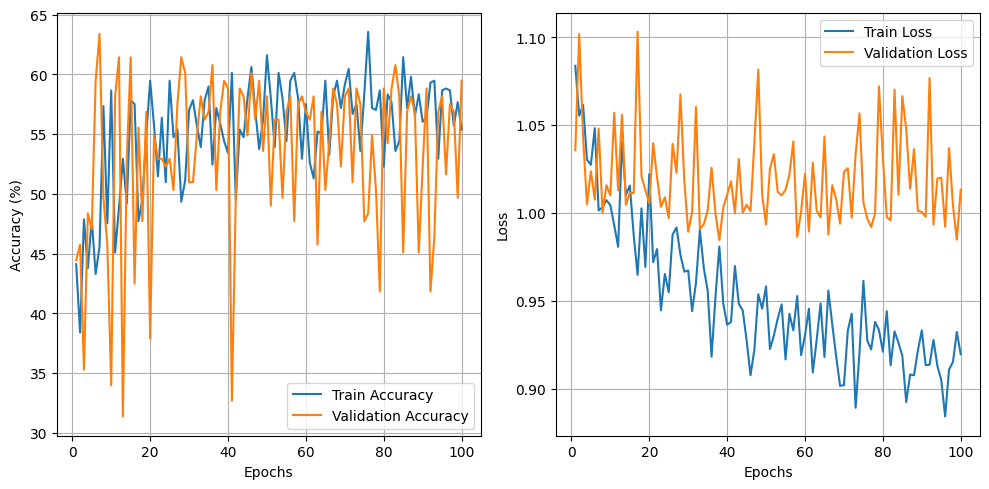

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/representacion_2/longitud_8/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v2/representacion_2/longitud_8/ConvNext_Tiny_fold_2.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

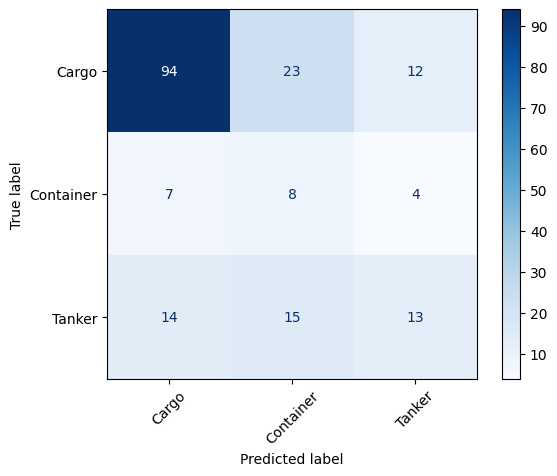

In [12]:
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v2/representacion_2/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       0.82      0.73      0.77       129
   Container       0.17      0.42      0.25        19
      Tanker       0.45      0.31      0.37        42

    accuracy                           0.61       190
   macro avg       0.48      0.49      0.46       190
weighted avg       0.67      0.61      0.63       190

